In [9]:
import scanpy as sc
import scvi
import os
import umap
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal, NegativeBinomial
from torch.distributions import kl_divergence as kl
import pandas as pd

from torch.optim import Adam
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

from nbVAE import VAE

DEVICE = torch.device("cpu")

In [10]:
### Load data and process ###

# data = sc.datasets.pbmc3k()
# data = sc.read_h5ad(os.path.join("data", "pbmc_68k", "pbmc_68k.h5ad"))
data = scvi.data.heart_cell_atlas_subsampled()

# Filter genes
sc.pp.filter_genes(data, min_counts=3)
data.layers["counts"] = data.X.copy()
sc.pp.highly_variable_genes(
    data,
    n_top_genes=1200,
    subset=True,
    flavor="seurat_v3",
    layer="counts",
    batch_key="cell_source"
)

# Normalize data (not necessary for nbVAE)
# sc.pp.normalize_per_cell(data, 1000)
# sc.pp.log1p(data)

X = (torch.from_numpy(data.X.toarray())).to(DEVICE)

INFO     File data/hca_subsampled_20k.h5ad already downloaded                                                      


In [11]:
### Set up model ###

batch_size = 512
n_vars = data.n_vars
n_obs = data.n_obs
epochs = 400
lr = 1e-3

vae = VAE(input_size=n_vars, latent_dims=10, hidden_dims=128)
vae = vae.to(DEVICE)

optimizer = Adam(vae.parameters(), lr=lr)

In [12]:
### Train model ###

for epoch in range(epochs):
    overall_loss = 0
    permutation = torch.randperm(n_obs)

    for i in range(0, n_obs, batch_size):
        indices = permutation[i:i+batch_size]
        x_batch = X[indices]

        optimizer.zero_grad()
        loss = vae(x_batch)

        overall_loss += loss.item()

        loss.backward()
        optimizer.step()

    print("Epoch", epoch + 1, "complete!", "\tAverage Loss: ", overall_loss / (i*batch_size))

print("Finished")

Epoch 1 complete! 	Average Loss:  0.01661149997057186
Epoch 2 complete! 	Average Loss:  0.004867653200765037
Epoch 3 complete! 	Average Loss:  0.0030543608979011574
Epoch 4 complete! 	Average Loss:  0.0024663139613241786
Epoch 5 complete! 	Average Loss:  0.0021965853520669043
Epoch 6 complete! 	Average Loss:  0.0020327742580169192
Epoch 7 complete! 	Average Loss:  0.0019041907637276584
Epoch 8 complete! 	Average Loss:  0.001759089251411044
Epoch 9 complete! 	Average Loss:  0.0016679497978960474
Epoch 10 complete! 	Average Loss:  0.001608725714807709
Epoch 11 complete! 	Average Loss:  0.001564093438598017
Epoch 12 complete! 	Average Loss:  0.0015326737161053137
Epoch 13 complete! 	Average Loss:  0.0015074854018166661
Epoch 14 complete! 	Average Loss:  0.0014900814211513433
Epoch 15 complete! 	Average Loss:  0.0014735379631424116
Epoch 16 complete! 	Average Loss:  0.0014591655959116502
Epoch 17 complete! 	Average Loss:  0.0014469414341470434
Epoch 18 complete! 	Average Loss:  0.001436253

In [13]:
# Draw latent z samples from means and logvars

z = vae.get_latents(X)
z = z.detach()
data.obsm["latent"] = z

/opt/miniconda3/envs/batch_effects/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


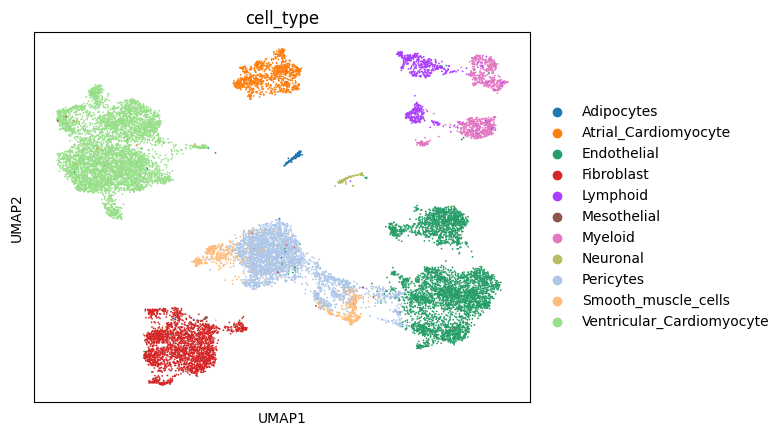

In [14]:
# Plot UMAP using scanpy

sc.pp.neighbors(data, use_rep="latent")
sc.tl.umap(data, min_dist=0.3)
sc.pl.umap(data, color=["cell_type"])

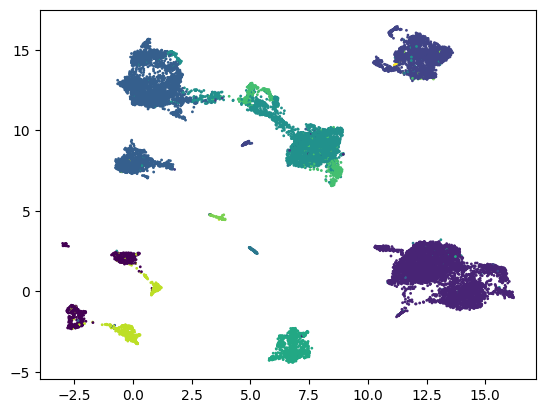

In [16]:
# Plot UMAP using matplotlib

z_embed = umap.UMAP().fit_transform(z)
# plt.scatter(z_embed[:,0], z_embed[:,1], s=1)
plt.scatter(z_embed[:,0], z_embed[:,1], c=data.obs["cell_type"].factorize()[0], s=1)